<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [3]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X=None 
y=None
length=10
spacing=1
folderpath='../Features'

for filename in os.listdir(folderpath):   
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        print(filename)
        label = 0
        if int(filename[9]) > 5:
          label = 1
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, label)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))

#All scenario correlated ONLY TO "length" and "spacing" variables
print(X)
print(y)
print(X.shape)
print(y.shape)

# Features scaling 
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X)
print(y)
print(X.shape)
print(y.shape)



Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (21591, 6)
current shape of y: (21591,)
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (43182, 6)
current shape of y: (43182,)
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of X: (64773, 6)
current shape of y: (64773,)
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (86364, 6)
current shape of y: (86364,)
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (107955, 6)
current shape of y: (107955,)
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (129546, 6)
current shape of y: (129546,)
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (151137, 6)
current shape of y: (151137,)
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (172728, 6)
current shape of y: (172728,)
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of

In [4]:
############################################################################################################
###### Perform XGBoost hyperparameters optimization via crossvalidation
###### Print hyperparameters obtained with crossvalidation in resfileXGB
###### Retrain an XGB model with best hyperparameters using the entire training set (X_train, y_train)
###### Print training results (best accuracy and training duration) in resfileXGB
###### Return the trained XGB model
###### for XGB with given hyperparameters space 
###### XGB documentation at: https://xgboost.readthedocs.io/en/stable/python/python_intro.html 
###### XGB hyperparameters: https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html 
############################################################################################################

best_params_XGB = None
best_cv_acc_XGB = None

def train_classifier_XGB(X_train, y_train, resfileXGB): 

    global best_params_XGB
    global best_cv_acc_XGB
    
    #F: define the search space for your hyperparameters - a space where to search
    # These parameters are needed to balance between underfitting and overfitting
    # We are testing 3 hyperparameters: eta, max_depth and subsample
    space4xgb = { 
     'eta': hp.choice('eta', [0.1, 0.3, 0.5, 0.7, 0.9, 1]),
     # max_depth (maximum depth of the decision trees being trained)
     'max_depth': hp.choice('max_depth', np.arange(1, 20, 2)),
     'subsample': hp.choice('subsample', [0.1, 0.3, 0.5, 0.7, 0.9, 1])
    }

    # hyperopt is used to perform an efficent search in the space of parameters
    def hyperopt_train_test(params):
        model = XGBClassifier(verbosity = 0, **params)
        #F: see https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
        
        return cross_val_score(model, X_train, y_train, cv = 5).mean()
        #F: cross_val_score is from scikit learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
        #F: will use the default score (for XGB it is accuracy)
        #F: this includes also training; cv=5 (5 number of folds) (5-folds crossvalidation)
        #F: .mean() is taken as cross_val_score returns an array of scores (one for each fold)
        # We have to do the mean because "cross_val_score" returns the accuracy of all the folds

    #We pass to this function the "space4xgb" parameter (in fmin() function)
    #F: this function is used below, as a parameter to fmin
    def f(params): 
        # assumes that "hyperopt_train_test" gives use the best cross validation accuracy 
        # given that combination of hyperparameters (params)
        acc = hyperopt_train_test(params)
        #F: loss is returned as opposite (negative) of accuracy because we will use in 
        #f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)
        # We need to return these parameters because fmin() requires them
        return {'loss': -acc, 'status': STATUS_OK} #F: loss is returned as opposite (negative) of accuracy because we will use in f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)

    if best_params_XGB is None:
        trials = Trials()
        # best_params stores the index of the best parameters values according to the function
        # fmin() returns the indexes based on the minimum value of a passed function "f"
        # space4xgb is the search space
        # algo=tpe.suggest is the used alorithm
        # max_evals=5 is the maximum trials
        best_params_XGB = fmin(f, space4xgb, algo=tpe.suggest, max_evals=5, trials=trials)
        #F: see: https://github.com/hyperopt/hyperopt/blob/master/hyperopt/fmin.py
        #F: at this point, best_param is a dictionary where each key is the index of the corresponding best param in space4xgb
        print(best_params_XGB)
    
        #Insert in the paramets the values of the hyperparameters (not the indexes)
        best_params_XGB = hyperopt.space_eval(space4xgb, best_params_XGB)
        #F: this is used to extract from space4xgb the best values according to the indexes in best_params (and put such values in best_params)
        print(best_params_XGB)
    
        best_cv_acc_XGB = -round(trials.best_trial['result']['loss'], 2) #F: best across trials
        print('best_cv_acc: ' + str(best_cv_acc_XGB))

    xgb = XGBClassifier(eta = best_params_XGB['eta'], max_depth= best_params_XGB['max_depth'], 
                            subsample = best_params_XGB['subsample'], verbosity = 0) 

    t0 = time.time()
    #F: fit() is a function from scikit learn interface for XGB (https://xgboost.readthedocs.io/en/stable/python/python_intro.html#scikit-learn-interface), 
    # there is also train() that can be used directly with XGB objects (https://xgboost.readthedocs.io/en/stable/python/python_intro.html#training) 
    xgb.fit(X_train, y_train) 
    t1 = time.time()

    with open(resfileXGB, 'w') as result_file:
        result_file.write('Best eta: {}\n'.format(best_params_XGB['eta']))
        result_file.write('Best max depth: {}\n'.format(best_params_XGB['max_depth']))
        result_file.write('Best subsample: {}\n'.format(best_params_XGB['subsample']))
        result_file.write('Crossvalidation accuracy: {}\n'.format(best_cv_acc_XGB))
        result_file.write('Training duration for XGB is {} s\n'.format(round(t1 - t0)))

    return xgb


In [5]:
############################################################################################################
###### Perform DNN hyperparameters optimization via crossvalidation
###### Print hyperparameters obtained with crossvalidation in resfileDNN
###### Retrain a DNN model with best hyperparameters using the entire training set (X_train, y_train)
###### Print training results (best accuracy and training duration) in resfileDNN
###### Return the trained DNN model
############################################################################################################

best_params_DNN = None
best_cv_acc_DNN = None

def train_classifier_DNN(X_train, y_train, resfileDNN): 

    global best_params_DNN
    global best_cv_acc_DNN

    #F: define the search space for your hyperparameters
    space4dnn = {
     'activation': hp.choice('activation', ['logistic', 'tanh', 'relu']),
     'neurons': hp.choice('neurons', [10, 50, 100]),
     'layers': hp.choice('layers', np.arange(1, 4, 1))
    }

    def hyperopt_train_test(params):
        size = (params['neurons'],) * params['layers']
        dnn = MLPClassifier(hidden_layer_sizes=size, activation=params['activation'],
                            solver='adam', learning_rate='invscaling', max_iter=1000)
        return cross_val_score(dnn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    if best_params_DNN is None:
        trials = Trials()
        best_params_DNN = fmin(f, space4dnn, algo=tpe.suggest, max_evals=5, trials=trials)
        print(best_params_DNN) 
    
        best_params_DNN = hyperopt.space_eval(space4dnn, best_params_DNN)
        print(best_params_DNN) 
    
        best_cv_acc_DNN = -round(trials.best_trial['result']['loss'], 2)
        print('best_cv_acc: ' + str(best_cv_acc_DNN))
    
    
    size = (best_params_DNN['neurons'],) * best_params_DNN['layers']
    dnn = MLPClassifier(hidden_layer_sizes=size, activation=best_params_DNN['activation'],
                                solver='adam', learning_rate='invscaling', max_iter=1000)

    t0 = time.time()
    dnn.fit(X_train, y_train)
    t1 = time.time()

    with open(resfileDNN, 'w') as result_file:
        result_file.write('Best number of layers: {}\n'.format(best_params_DNN['layers']))
        result_file.write('Best number of neurons: {}\n'.format(best_params_DNN['neurons']))
        result_file.write('Best activation function: {}\n'.format(best_params_DNN['activation']))
        result_file.write('Crossvalidation accuracy: {}\n'.format(best_cv_acc_DNN))
        result_file.write('Training duration for DNN is {} s\n'.format(round(t1 - t0)))

    return dnn


In [6]:
############################################################################################################
###### Perform KNN hyperparameters optimization via crossvalidation
###### Print hyperparameters obtained with crossvalidation in resfileKNN
###### Retrain a KNN model with best hyperparameters using the entire training set (X_train, y_train)
###### Print training results (best accuracy and training duration) in resfileKNN
###### Return the trained KNN model
############################################################################################################

best_params_KNN = None
best_cv_acc_KNN = None

def train_classifier_KNN(X_train, y_train, resfileKNN): 

    global best_params_KNN
    global best_cv_acc_KNN

    #F: define the search space for your hyperparameters
    space4knn = {
     'leaf_size': hp.choice('leaf_size', np.arange(1, 50, 1)),
     'p': hp.choice('p', [1, 2]),
     'n_neighbors': hp.choice('n_neighbors', np.arange(1, 30, 1))
    }

    def hyperopt_train_test(params):
        knn = KNeighborsClassifier(leaf_size=params['leaf_size'], p=params['p'], 
                                   n_neighbors=params['n_neighbors'])
        return cross_val_score(knn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    if best_params_KNN is None:
        trials = Trials()
        best_params_KNN = fmin(f, space4knn, algo=tpe.suggest, max_evals=5, trials=trials)
        print(best_params_KNN) 
    
        best_params_KNN = hyperopt.space_eval(space4knn, best_params_KNN)
        print(best_params_KNN) 
    
        best_cv_acc_KNN = -round(trials.best_trial['result']['loss'], 2)
        print('best_cv_acc: ' + str(best_cv_acc_KNN))
    
    knn = KNeighborsClassifier(leaf_size=best_params_KNN['leaf_size'], p=best_params_KNN['p'], 
                                   n_neighbors=best_params_KNN['n_neighbors'])

    t0 = time.time()
    knn.fit(X_train, y_train)
    t1 = time.time()

    with open(resfileKNN, 'w') as result_file:
        result_file.write('Best leaf_size: {}\n'.format(best_params_KNN['leaf_size']))
        result_file.write('Best number of p: {}\n'.format(best_params_KNN['p']))
        result_file.write('Best number of neighbors: {}\n'.format(best_params_KNN['n_neighbors']))
        result_file.write('Crossvalidation accuracy: {}\n'.format(best_cv_acc_KNN))
        result_file.write('Training duration for kNN is {} s\n'.format(round(t1 - t0)))

    return knn


In [7]:
################################################################################################################
###### Split into into train/test and call train_classifier_XXX() functions
################################################################################################################

res_folder = '1_4_Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

model_folder = '1_4_Models'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Stratify garantees the split all the scenarios among train and test
# It's like shuffle and split
# random_state it's a seed to get the same output

xgbmodelfiles = []
dnnmodelfiles = []
knnmodelfiles = []

percentages = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

for i in percentages:
    resfile_XGB=res_folder + '/XGB_sp_' + str(spacing) + 'w_' + str(length) + 't_' + str(i)  + '_results.txt'
    resfile_DNN=res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + 't_' + str(i)  + '_results.txt'
    resfile_KNN=res_folder + '/KNN_sp_' + str(spacing) + 'w_' + str(length) + 't_' + str(i)  + '_results.txt'

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=i, random_state=42)
    print(f'Training XGB with training size: {i*100}%...')
    xgb = train_classifier_XGB(X_train, y_train, resfile_XGB)
    print(f'Training DNN with training size: {i*100}%...')
    dnn = train_classifier_DNN(X_train, y_train, resfile_DNN)
    print(f'Training KNN with training size: {i*100}%...')
    knn = train_classifier_KNN(X_train, y_train, resfile_KNN)
    
    # Define model names
    xgbmodelfile = model_folder + '/XGB_sp{}_w{}_t{}.json'.format(spacing, length, i) 
    dnnmodelfile = model_folder + '/DNN_sp{}_w{}_t{}.json'.format(spacing, length, i)
    knnmodelfile = model_folder + '/KNN_sp{}_w{}_t{}.json'.format(spacing, length, i)
    
    xgbmodelfiles.append(xgbmodelfile)
    dnnmodelfiles.append(dnnmodelfile)
    knnmodelfiles.append(knnmodelfile)
    
    # Save the models to disk
    xgb.save_model(xgbmodelfile)
    pickle.dump(dnn, open(dnnmodelfile, 'wb'))
    pickle.dump(knn, open(knnmodelfile, 'wb'))

Training XGB with training size: 1.0%...
100%|██████████| 5/5 [00:02<00:00,  1.85trial/s, best loss: -0.9987172904117705]
{'eta': 3, 'max_depth': 6, 'subsample': 5}
{'eta': 0.7, 'max_depth': 13, 'subsample': 1}
best_cv_acc: 1.0
Training DNN with training size: 1.0%...
100%|██████████| 5/5 [01:42<00:00, 20.46s/trial, best loss: -0.9948708074125274]
{'activation': 0, 'layers': 1, 'neurons': 1}
{'activation': 'logistic', 'layers': 2, 'neurons': 50}
best_cv_acc: 0.99
Training KNN with training size: 1.0%...
100%|██████████| 5/5 [00:00<00:00,  6.51trial/s, best loss: -0.9928188670550673]
{'leaf_size': 0, 'n_neighbors': 4, 'p': 0}
{'leaf_size': 1, 'n_neighbors': 5, 'p': 1}
best_cv_acc: 0.99


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 2.0%...
Training DNN with training size: 2.0%...
Training KNN with training size: 2.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 4.0%...
Training DNN with training size: 4.0%...
Training KNN with training size: 4.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 6.0%...
Training DNN with training size: 6.0%...
Training KNN with training size: 6.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 8.0%...
Training DNN with training size: 8.0%...
Training KNN with training size: 8.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 10.0%...
Training DNN with training size: 10.0%...
Training KNN with training size: 10.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 20.0%...
Training DNN with training size: 20.0%...
Training KNN with training size: 20.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 30.0%...
Training DNN with training size: 30.0%...
Training KNN with training size: 30.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 40.0%...
Training DNN with training size: 40.0%...
Training KNN with training size: 40.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 50.0%...
Training DNN with training size: 50.0%...
Training KNN with training size: 50.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 60.0%...
Training DNN with training size: 60.0%...
Training KNN with training size: 60.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 70.0%...
Training DNN with training size: 70.0%...
Training KNN with training size: 70.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 80.0%...
Training DNN with training size: 80.0%...
Training KNN with training size: 80.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 90.0%...
Training DNN with training size: 90.0%...
Training KNN with training size: 90.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 99.0%...
Training DNN with training size: 99.0%...
Training KNN with training size: 99.0%...


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


In [8]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names, resfile):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    cm = confusion_matrix(y_true, y_pred)
    #F: normalized wrt true labels (axis=1 sums the elements of one row and sums them; this is done for all the rows independently)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

    with open(resfile, 'w') as result_file:
        result_file.write('Results for the TEST SET\n')
        result_file.write('Accuracy: {}\n'.format(accuracy))
        result_file.write('Precision per class: {}\n'.format(precision))
        result_file.write('Global Precision: {}\n'.format(global_precision))
        result_file.write('Recall per class: {}\n'.format(recall))
        result_file.write('Global Recall: {}\n'.format(global_recall))
        result_file.write('F1-score: {}\n'.format(f1score))
        result_file.write('Global F1-score: {}\n'.format(global_f1score))

        result_file.write('\nNormalized confusion matrix\n')
        result_file.write(str(cm_norm))

# ------------------------------- normalized cm -------------------------------
        title_norm = 'Confusion matrix, with normalization'
        fig_n, ax_n = plt.subplots()
        im = ax_n.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
        ax_n.figure.colorbar(im, ax=ax_n)
        # We want to show all ticks...
        ax_n.set(xticks=np.arange(cm_norm.shape[1]),
               yticks=np.arange(cm_norm.shape[0]),
               # ... and label them with the respective list entries
               #xticklabels=lab, yticklabels=lab,
               xticklabels=l_names, yticklabels=l_names,
               title=title_norm,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions (#F: i.e., cells in the confusion matrix) and create text annotations. 
        fmt = '.2f'
        thresh = cm_norm.max() / 2.
        for w in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                ax_n.text(j, w, format(cm_norm[w, j], fmt),
                        ha="center", va="center",
                        color="white" if cm_norm[w, j] > thresh else "black")
        fig_n.tight_layout()
        fig_n.savefig(resfile.replace('.txt','_conf_matrix_normalized.png'))
        plt.show()

########################################################################
# Now we return the global metrics (Accuracy, Precision, Recall, F1-score) calculated above

    return accuracy, global_precision, global_recall, global_f1score 


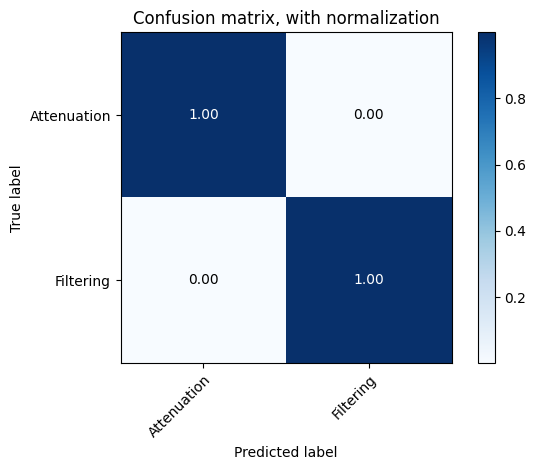

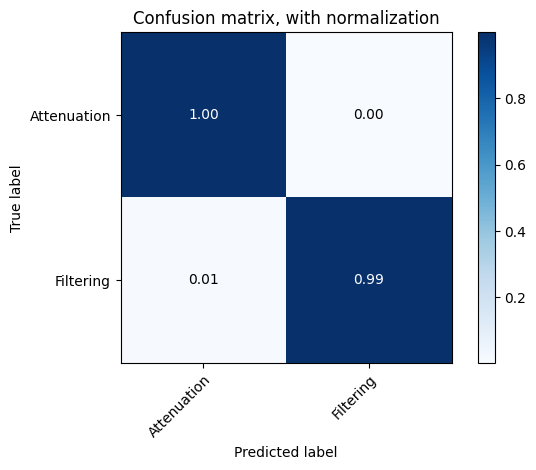

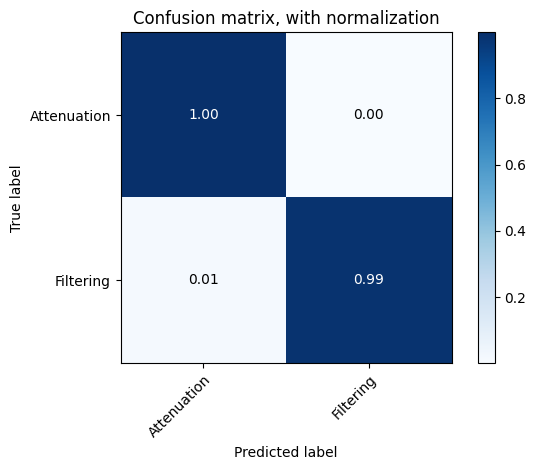

XGB metrics for training size 1.0%: (0.9987176199025392, 0.9987196721099748, 0.9987176199025392, 0.9987179836573402)
****************
DNN metrics for training size 1.0%: (0.9951269556296486, 0.9951276495958989, 0.9951269556296486, 0.9951236989963483)
****************
KNN metrics for training size 1.0%: (0.9946140035906643, 0.9946316331360335, 0.9946140035906643, 0.9946062308429098)


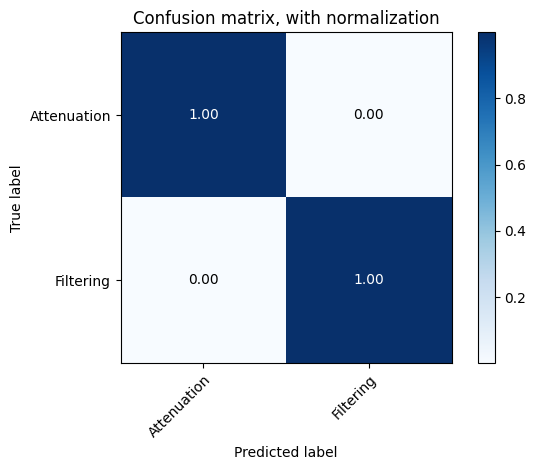

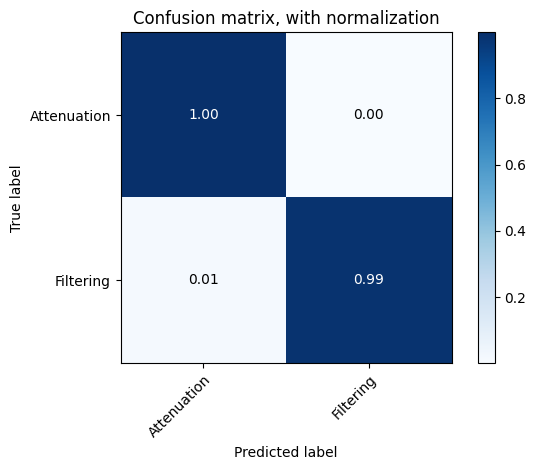

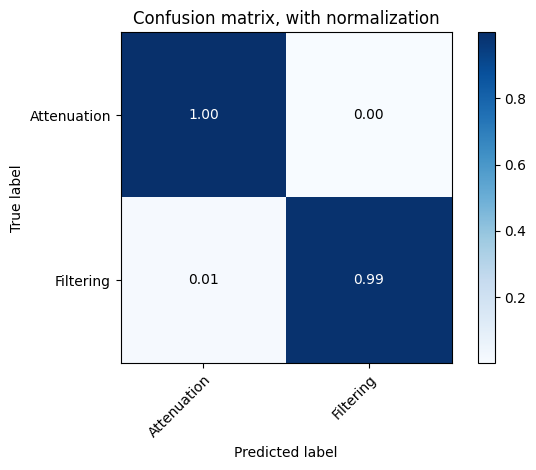

XGB metrics for training size 2.0%: (0.9992305719415234, 0.9992308651194198, 0.9992305719415234, 0.9992306448335696)
****************
DNN metrics for training size 2.0%: (0.9943575275711721, 0.9943712207724485, 0.9943575275711721, 0.9943499348577328)
****************
KNN metrics for training size 2.0%: (0.995639907668633, 0.9956539531444888, 0.995639907668633, 0.9956344648901159)


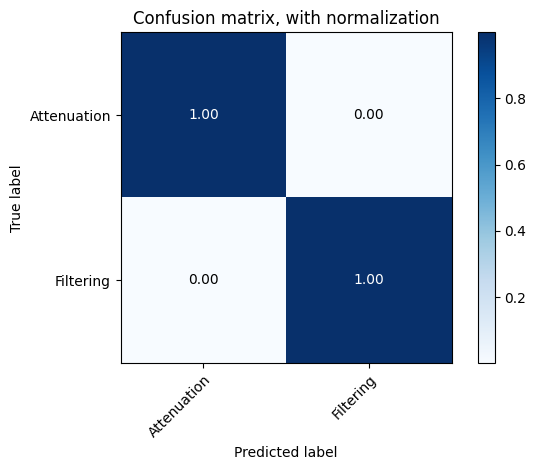

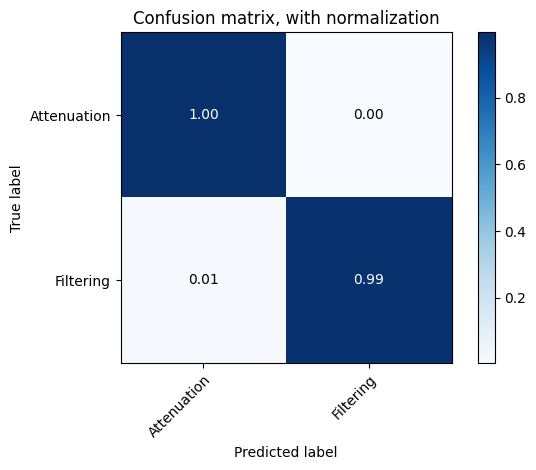

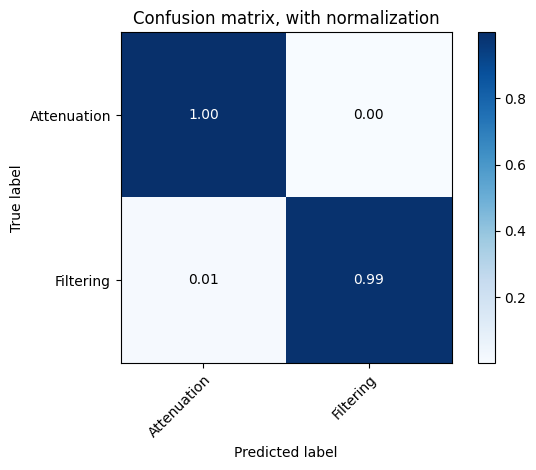

XGB metrics for training size 4.0%: (0.9989740959220312, 0.9989750734677791, 0.9989740959220312, 0.9989742901126566)
****************
DNN metrics for training size 4.0%: (0.9938445755321877, 0.9938474900375908, 0.9938445755321877, 0.9938386818752876)
****************
KNN metrics for training size 4.0%: (0.9958963836881252, 0.9959081773045652, 0.9958963836881252, 0.9958916596702204)


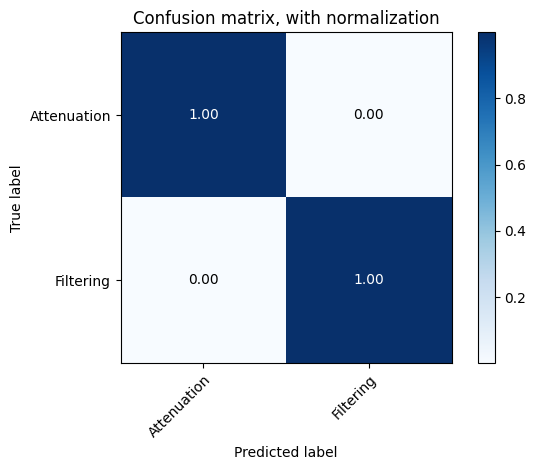

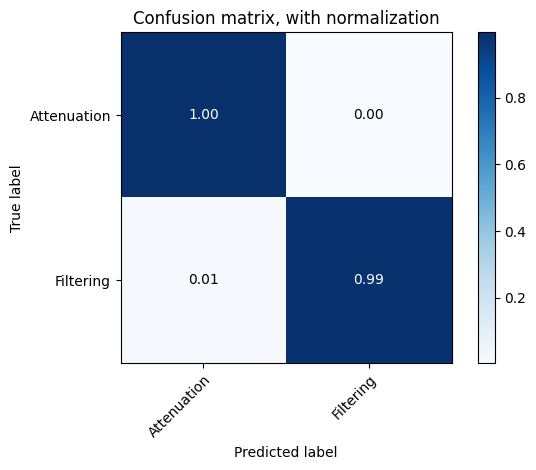

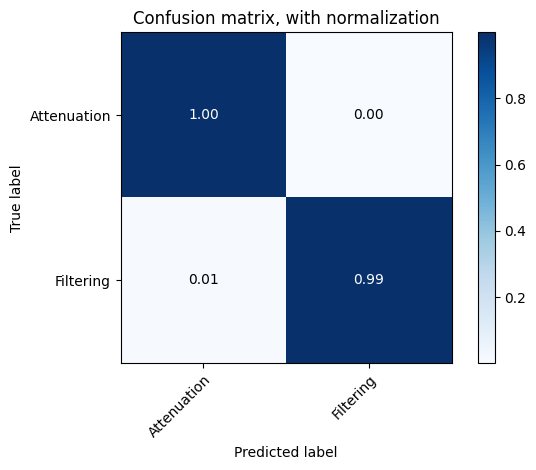

XGB metrics for training size 6.0%: (0.998461143883047, 0.9984646601526226, 0.998461143883047, 0.998461725326834)
****************
DNN metrics for training size 6.0%: (0.9941010515516799, 0.9941003650245777, 0.9941010515516799, 0.9940971093113691)
****************
KNN metrics for training size 6.0%: (0.997178763785586, 0.9971822187385416, 0.997178763785586, 0.997176878366307)


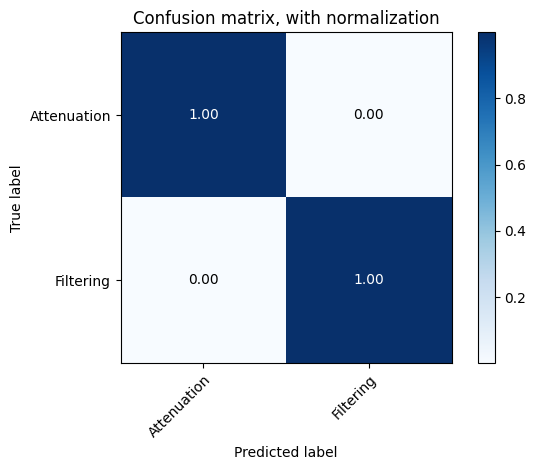

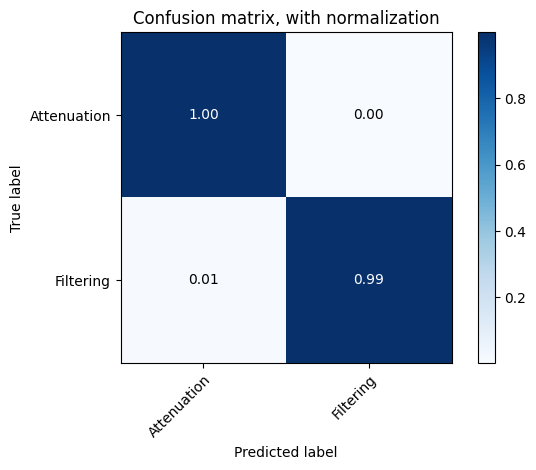

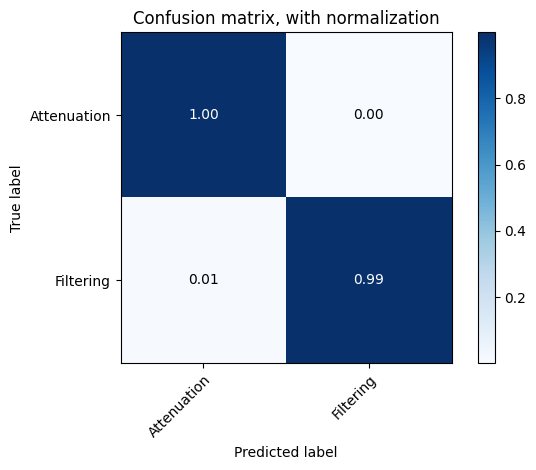

XGB metrics for training size 8.0%: (0.9987176199025392, 0.9987196721099748, 0.9987176199025392, 0.9987179836573402)
****************
DNN metrics for training size 8.0%: (0.9951269556296486, 0.9951276495958989, 0.9951269556296486, 0.9951236989963483)
****************
KNN metrics for training size 8.0%: (0.997178763785586, 0.9971822187385416, 0.997178763785586, 0.997176878366307)


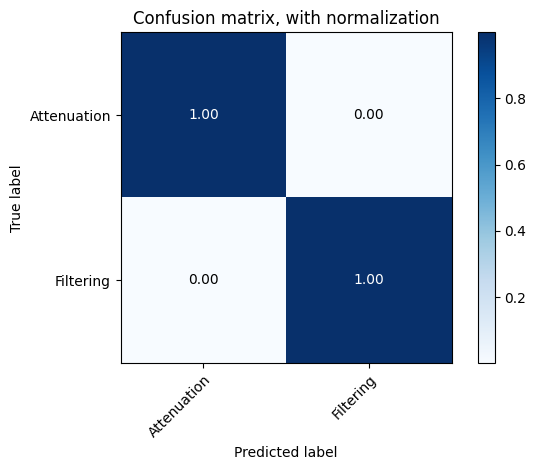

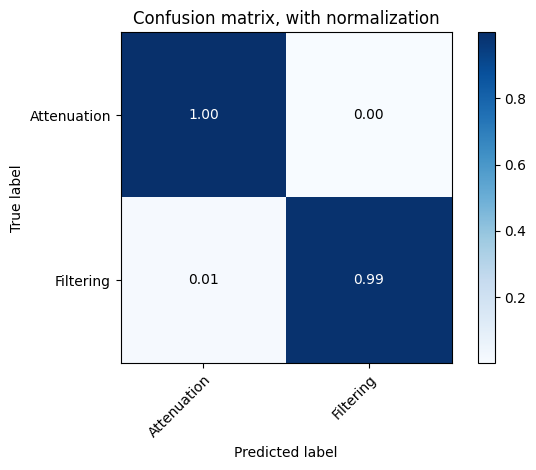

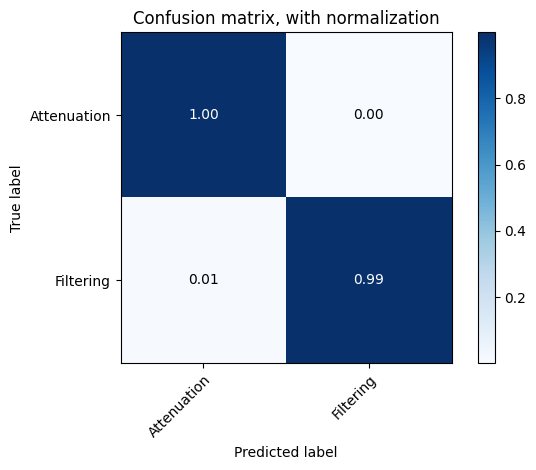

XGB metrics for training size 10.0%: (0.9987176199025392, 0.9987196721099748, 0.9987176199025392, 0.9987179836573402)
****************
DNN metrics for training size 10.0%: (0.9951269556296486, 0.995139704371783, 0.9951269556296486, 0.995120872524247)
****************
KNN metrics for training size 10.0%: (0.9976917158245704, 0.9976932025127974, 0.9976917158245704, 0.9976906160814875)


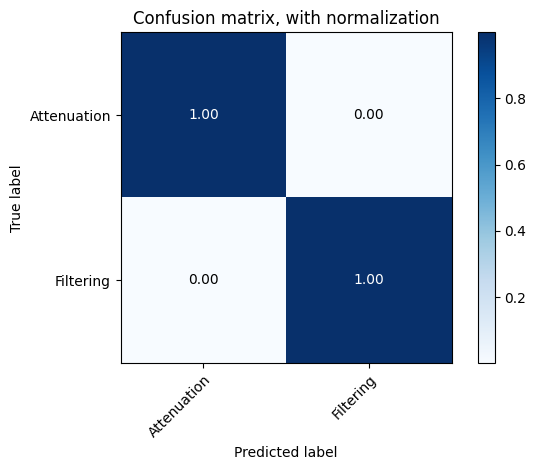

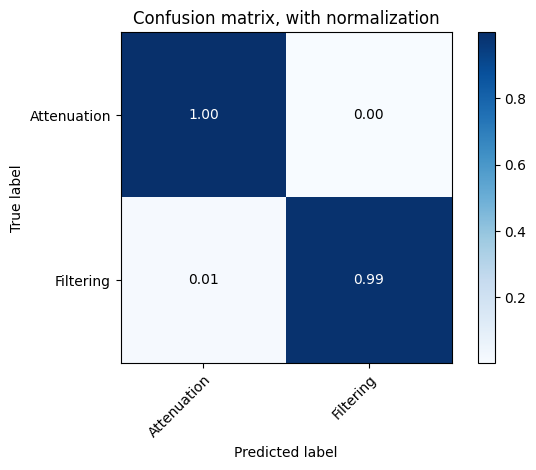

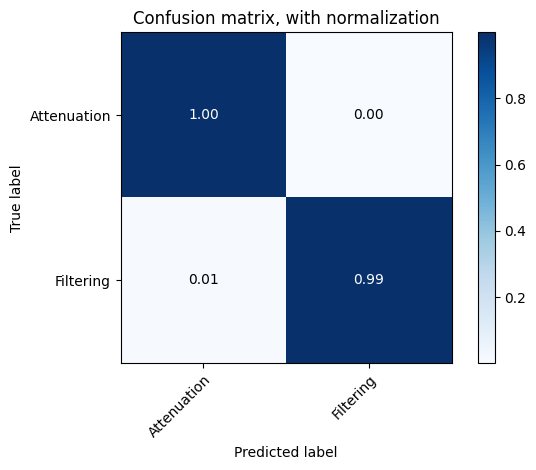

XGB metrics for training size 20.0%: (0.9989740959220312, 0.9989750734677791, 0.9989740959220312, 0.9989742901126566)
****************
DNN metrics for training size 20.0%: (0.9946140035906643, 0.9946166454600809, 0.9946140035906643, 0.9946093668074127)
****************
KNN metrics for training size 20.0%: (0.9976917158245704, 0.9976932025127974, 0.9976917158245704, 0.9976906160814875)


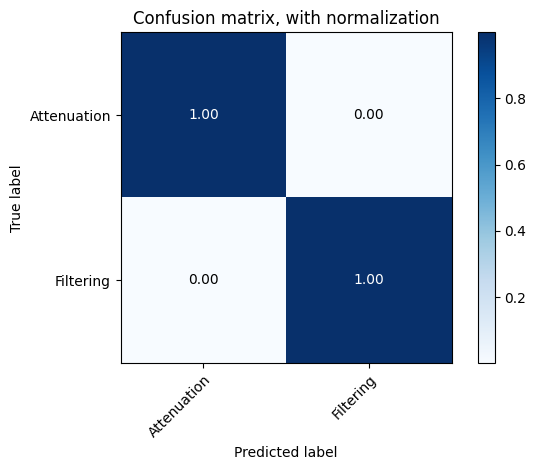

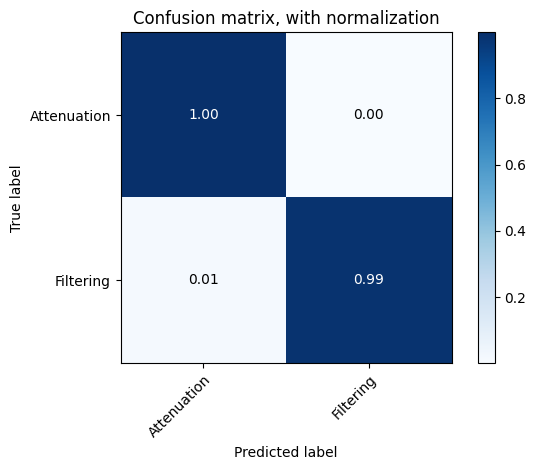

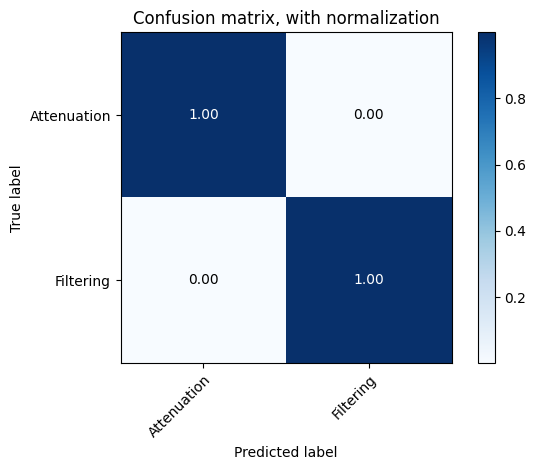

XGB metrics for training size 30.0%: (0.9989740959220312, 0.9989750734677791, 0.9989740959220312, 0.9989742901126566)
****************
DNN metrics for training size 30.0%: (0.9946140035906643, 0.9946316331360335, 0.9946140035906643, 0.9946062308429098)
****************
KNN metrics for training size 30.0%: (0.998461143883047, 0.998461143883047, 0.998461143883047, 0.998461143883047)


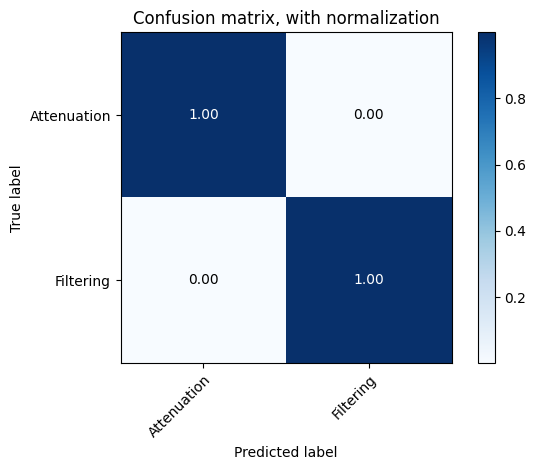

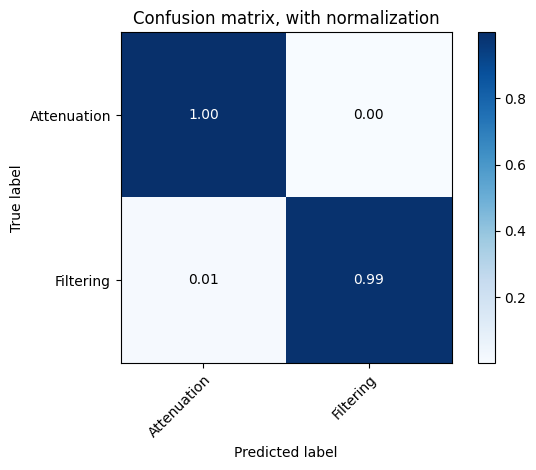

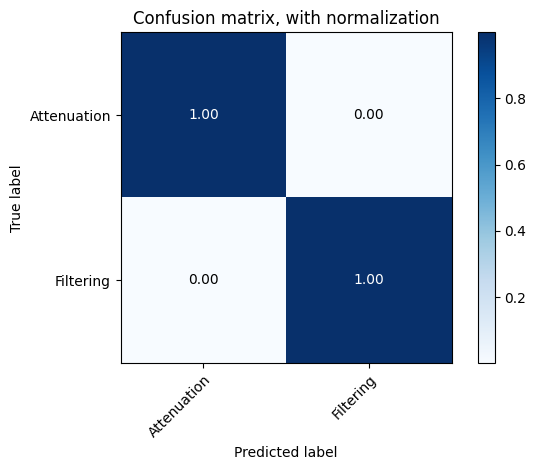

XGB metrics for training size 40.0%: (0.9987176199025392, 0.9987196721099748, 0.9987176199025392, 0.9987179836573402)
****************
DNN metrics for training size 40.0%: (0.9953834316491408, 0.9953940305709577, 0.9953834316491408, 0.995378117128998)
****************
KNN metrics for training size 40.0%: (0.998461143883047, 0.9984623152433904, 0.998461143883047, 0.9984614351689846)


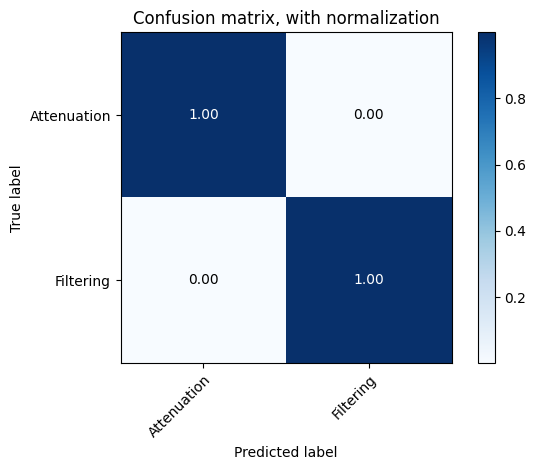

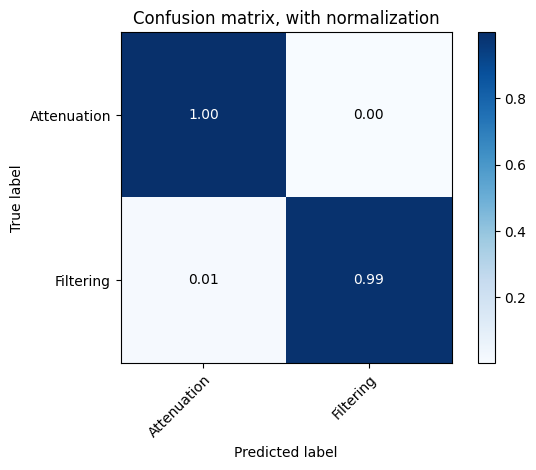

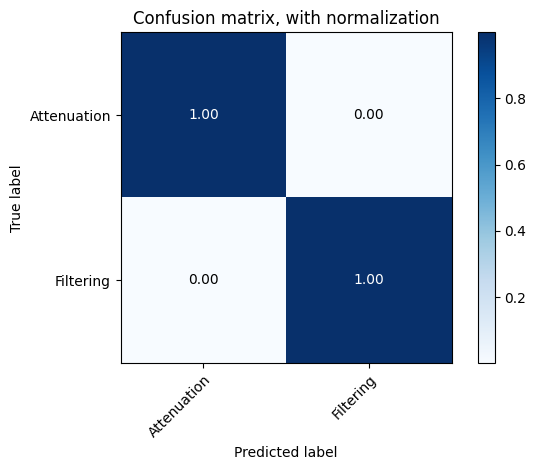

XGB metrics for training size 50.0%: (0.9994870479610156, 0.9994870479610156, 0.9994870479610156, 0.9994870479610156)
****************
DNN metrics for training size 50.0%: (0.9943575275711721, 0.9943614338443852, 0.9943575275711721, 0.9943521250523469)
****************
KNN metrics for training size 50.0%: (0.9987176199025392, 0.9987180101757479, 0.9987176199025392, 0.9987177413892825)


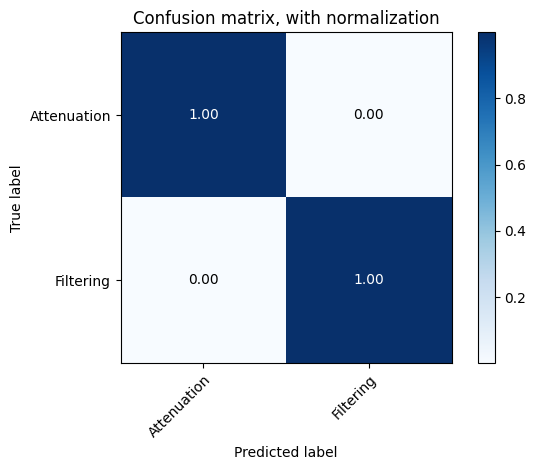

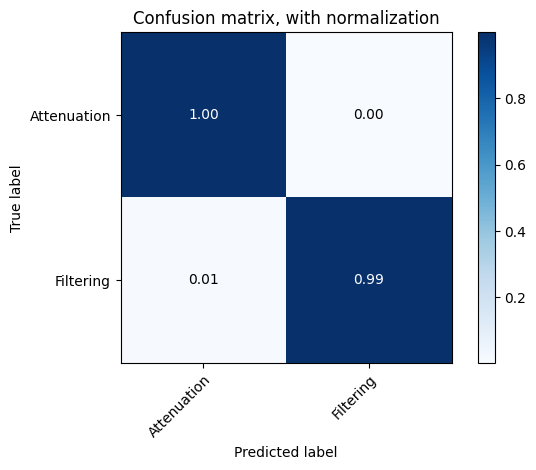

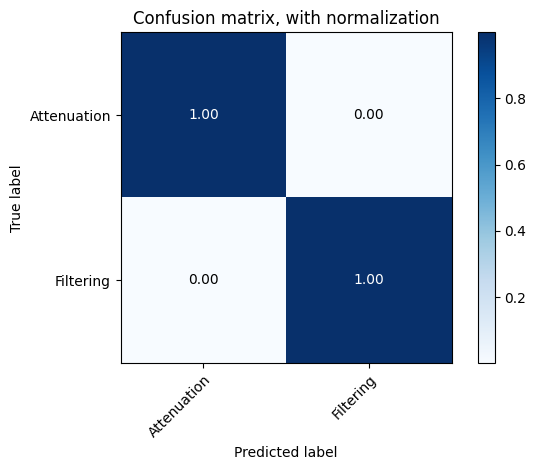

XGB metrics for training size 60.0%: (0.9989740959220312, 0.9989750734677791, 0.9989740959220312, 0.9989742901126566)
****************
DNN metrics for training size 60.0%: (0.9961528597076174, 0.9961519879310837, 0.9961528597076174, 0.9961517620875923)
****************
KNN metrics for training size 60.0%: (0.9989740959220312, 0.9989740959220312, 0.9989740959220312, 0.9989740959220312)


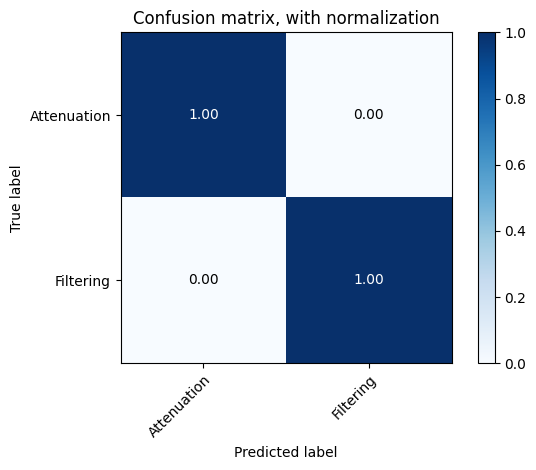

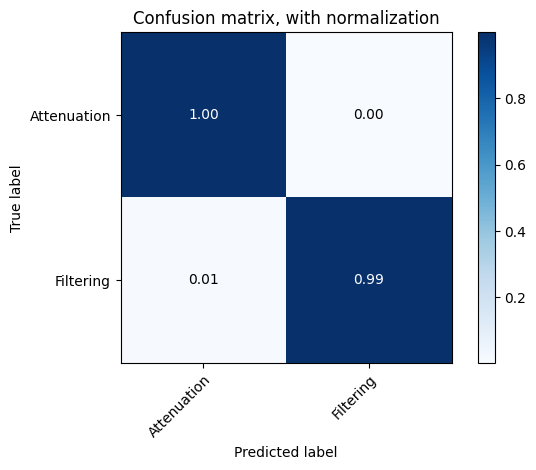

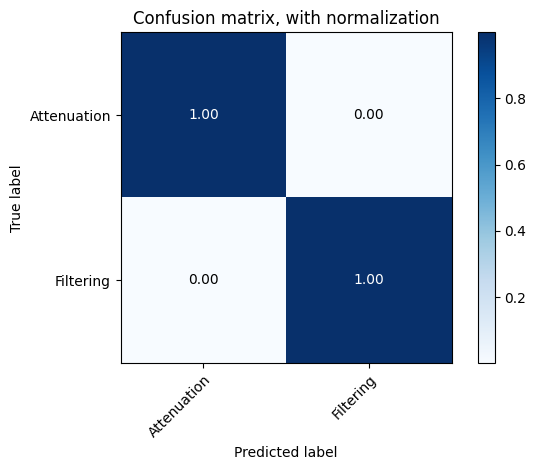

XGB metrics for training size 70.0%: (0.9997435239805078, 0.9997437200630915, 0.9997435239805078, 0.9997435482778564)
****************
DNN metrics for training size 70.0%: (0.9951269556296486, 0.9951276495958989, 0.9951269556296486, 0.9951236989963483)
****************
KNN metrics for training size 70.0%: (0.998461143883047, 0.998461143883047, 0.998461143883047, 0.998461143883047)


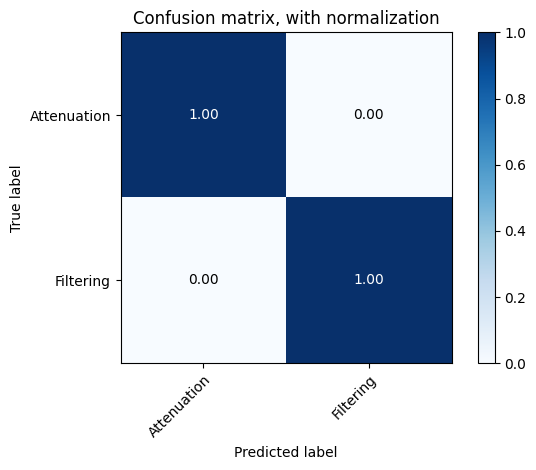

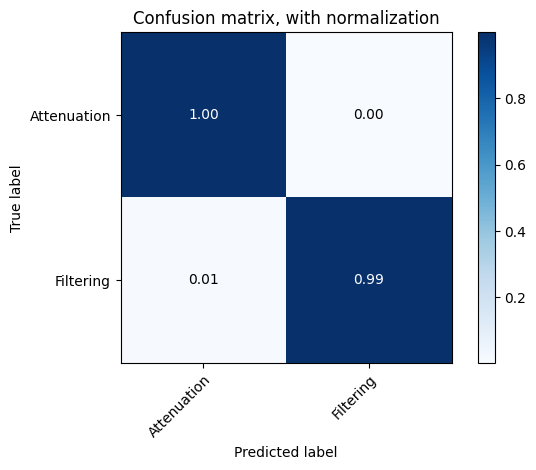

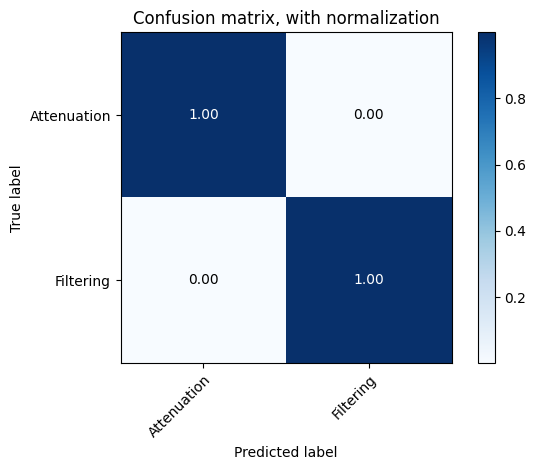

XGB metrics for training size 80.0%: (0.9994870479610156, 0.9994878316921677, 0.9994870479610156, 0.9994871450563283)
****************
DNN metrics for training size 80.0%: (0.9951269556296486, 0.9951276495958989, 0.9951269556296486, 0.9951236989963483)
****************
KNN metrics for training size 80.0%: (0.9987176199025392, 0.9987180101757479, 0.9987176199025392, 0.9987177413892825)


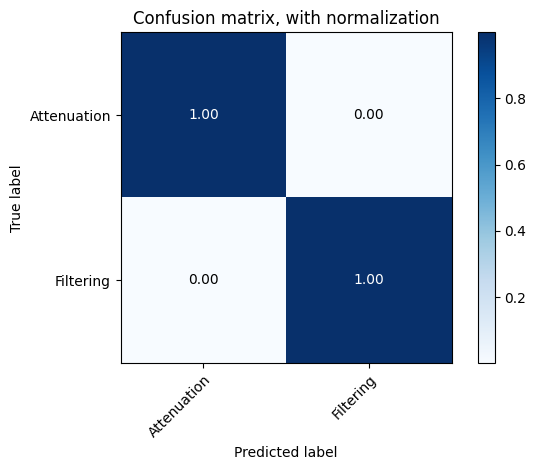

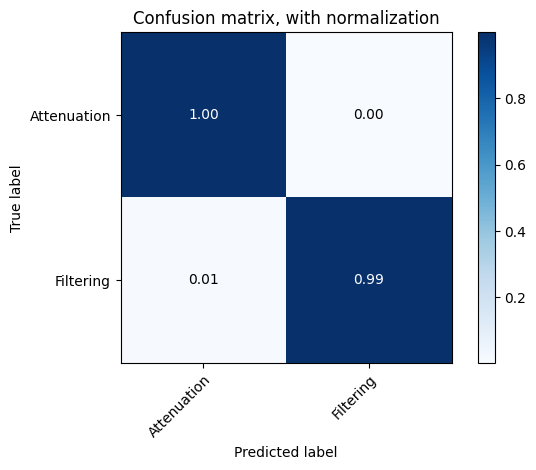

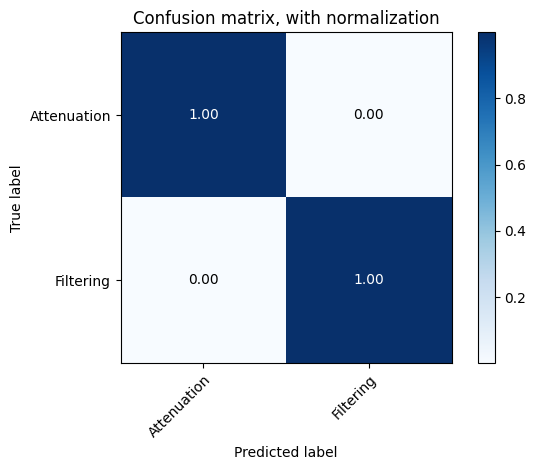

XGB metrics for training size 90.0%: (0.9994870479610156, 0.9994870479610156, 0.9994870479610156, 0.9994870479610156)
****************
DNN metrics for training size 90.0%: (0.9953834316491408, 0.9953834425759363, 0.9953834316491408, 0.9953807897160311)
****************
KNN metrics for training size 90.0%: (0.9987176199025392, 0.9987180101757479, 0.9987176199025392, 0.9987177413892825)


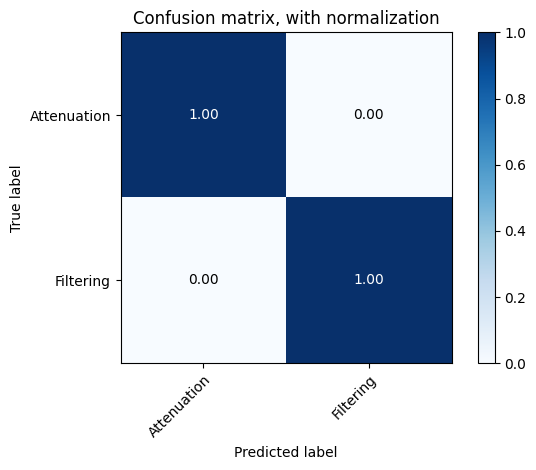

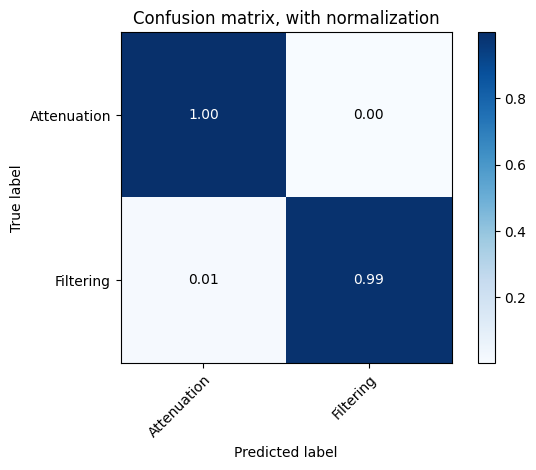

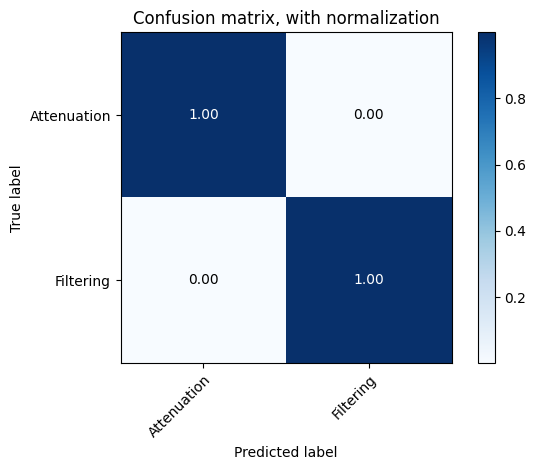

XGB metrics for training size 99.0%: (0.9997435239805078, 0.9997437200630915, 0.9997435239805078, 0.9997435482778564)
****************
DNN metrics for training size 99.0%: (0.9948704796101564, 0.9948720506339888, 0.9948704796101564, 0.9948665580744186)
****************
KNN metrics for training size 99.0%: (0.9987176199025392, 0.9987180101757479, 0.9987176199025392, 0.9987177413892825)


In [9]:
##############################################################################################################
###### Load models into NEW models, perform prediction and evaluate performance using performance_eval() 
##############################################################################################################
lbl = [0, 1]
label_names=['Attenuation', 'Filtering']

XGB_all_metrics = []
DNN_all_metrics = []
KNN_all_metrics = []
    
for i in percentages:
    restestfileXGB = res_folder + '/XGB_sp_' + str(spacing) + 'w_' + str(length) + 't_' + str(i) + '_test_results.txt'
    restestfileDNN = res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + 't_' + str(i) + '_test_results.txt'
    restestfileKNN = res_folder + '/KNN_sp_' + str(spacing) + 'w_' + str(length) + 't_' + str(i) + '_test_results.txt'

    # load the model from disk
    loaded_xgb = XGBClassifier()
    loaded_xgb.load_model(xgbmodelfiles.pop(0))

    # load the model from disk
    loaded_dnn = pickle.load(open(dnnmodelfiles.pop(0), 'rb'))

    # load the model from disk
    loaded_knn = pickle.load(open(knnmodelfiles.pop(0), 'rb'))

    # Added to fix: 'XGBClassifier' object has no attribute '_le'
    loaded_xgb._le = LabelEncoder().fit(y_test)

    y_pred_XGB = loaded_xgb.predict(X_test)
    y_pred_DNN = loaded_dnn.predict(X_test)
    y_pred_KNN = loaded_knn.predict(X_test)

    XGB_simgle_metrics = performance_eval(y_test, y_pred_XGB, lbl, label_names, restestfileXGB)
    DNN_single_metrics = performance_eval(y_test, y_pred_DNN, lbl, label_names, restestfileDNN)
    KNN_single_metrics = performance_eval(y_test, y_pred_KNN, lbl, label_names, restestfileKNN)

    XGB_all_metrics.append(XGB_simgle_metrics)
    DNN_all_metrics.append(DNN_single_metrics)
    KNN_all_metrics.append(KNN_single_metrics)

    print('XGB metrics for training size '+str(i*100)+ '%: '+str(XGB_simgle_metrics))
    print('****************')
    print('DNN metrics for training size '+str(i*100)+ '%: '+str(DNN_single_metrics))
    print('****************')
    print('KNN metrics for training size '+str(i*100)+ '%: '+str(KNN_single_metrics))

In [11]:
def draw_stats(XGB_vals, DNN_vals, KNN_vals, stats_label):
    fig_folder = '1_4_Figures'
    if not os.path.exists(fig_folder):
        os.makedirs(fig_folder)
    
    percentages_local = [x * 100 for x in percentages]
    fig, ax = plt.subplots(figsize=(15,8))
    plt.grid(1)
    plt.plot(percentages_local, XGB_vals, color='red', label='XGB')
    plt.plot(percentages_local, DNN_vals, color='blue', label='DNN')
    plt.plot(percentages_local, KNN_vals, color='green', label='KNN')
    image_title = 'Impact of training set size on '+stats_label
    plt.title(image_title, pad=25)
    plt.xlabel('Percentage')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')

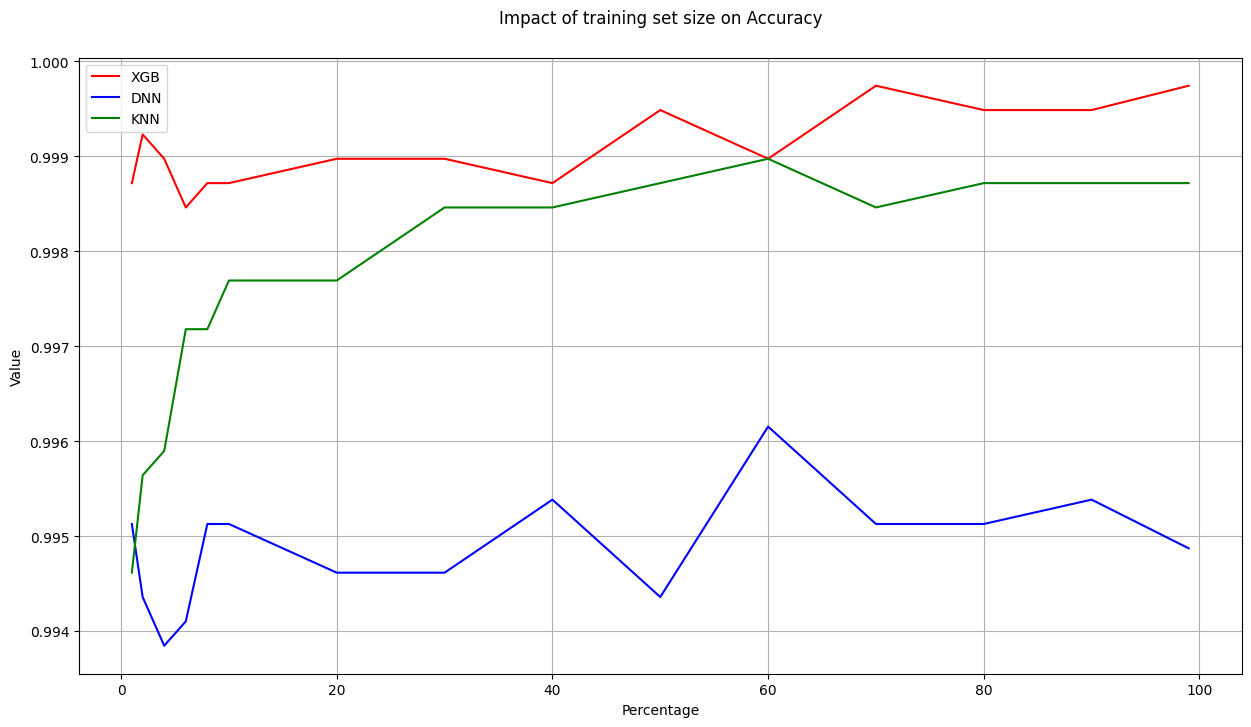

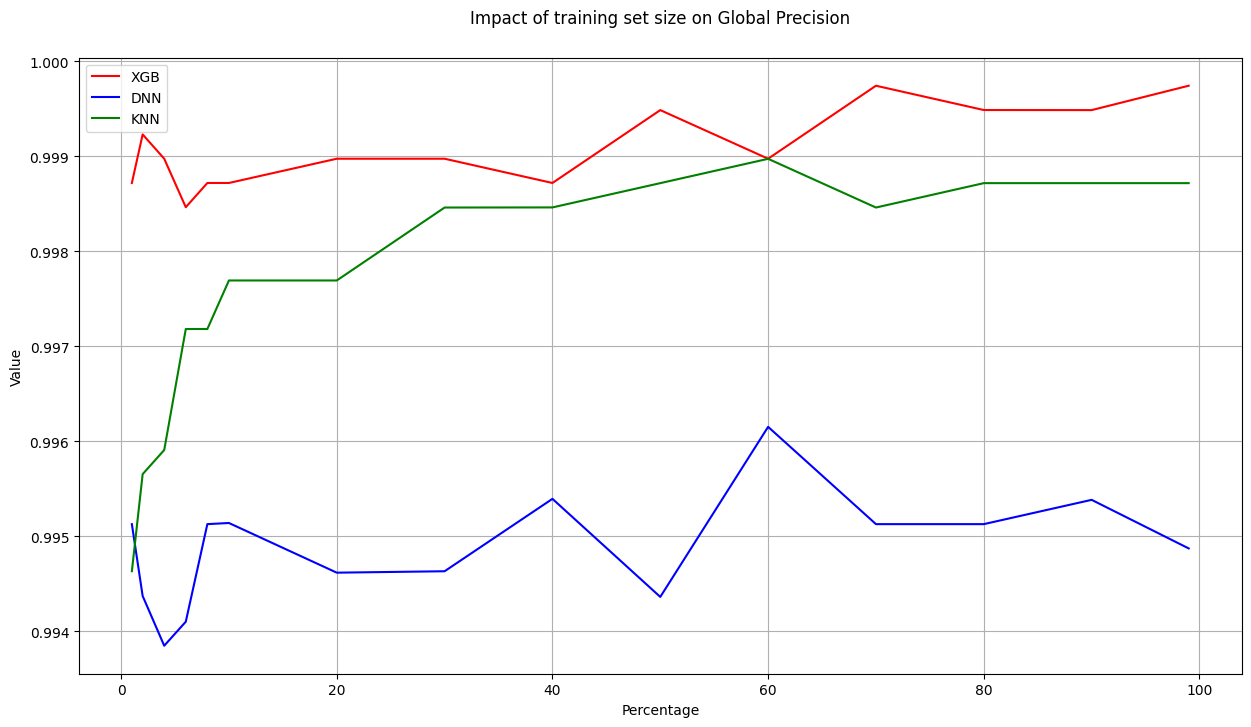

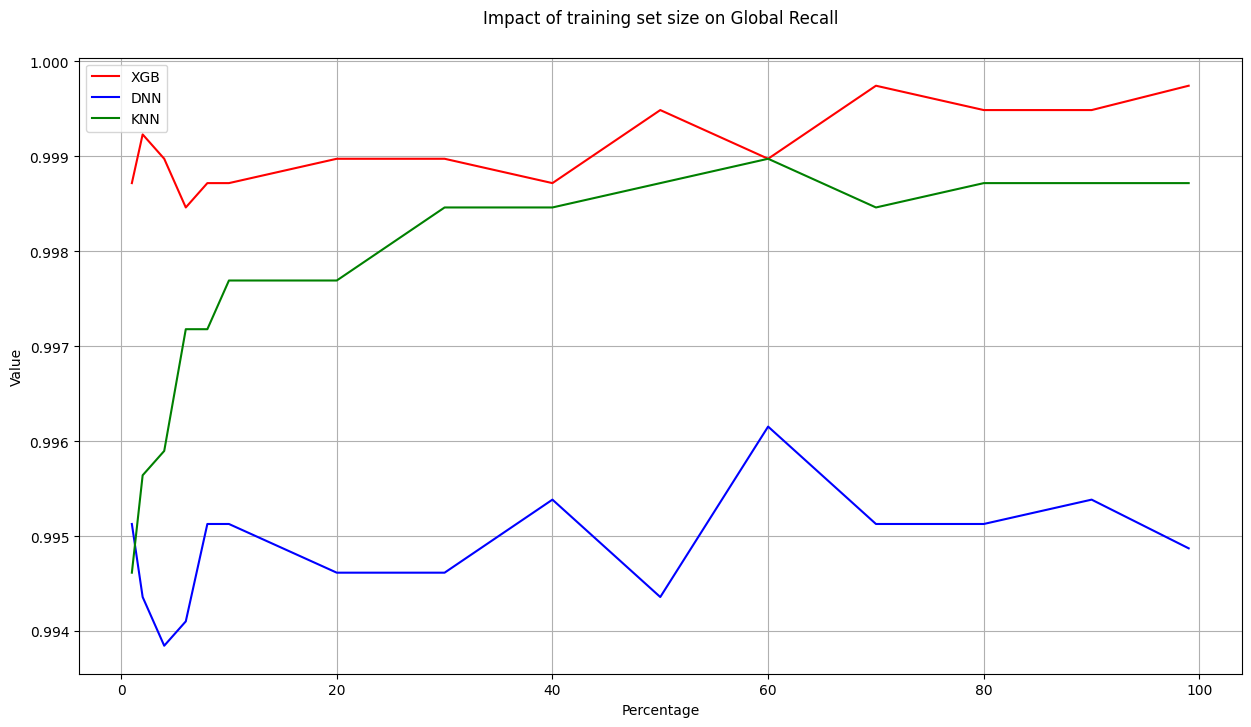

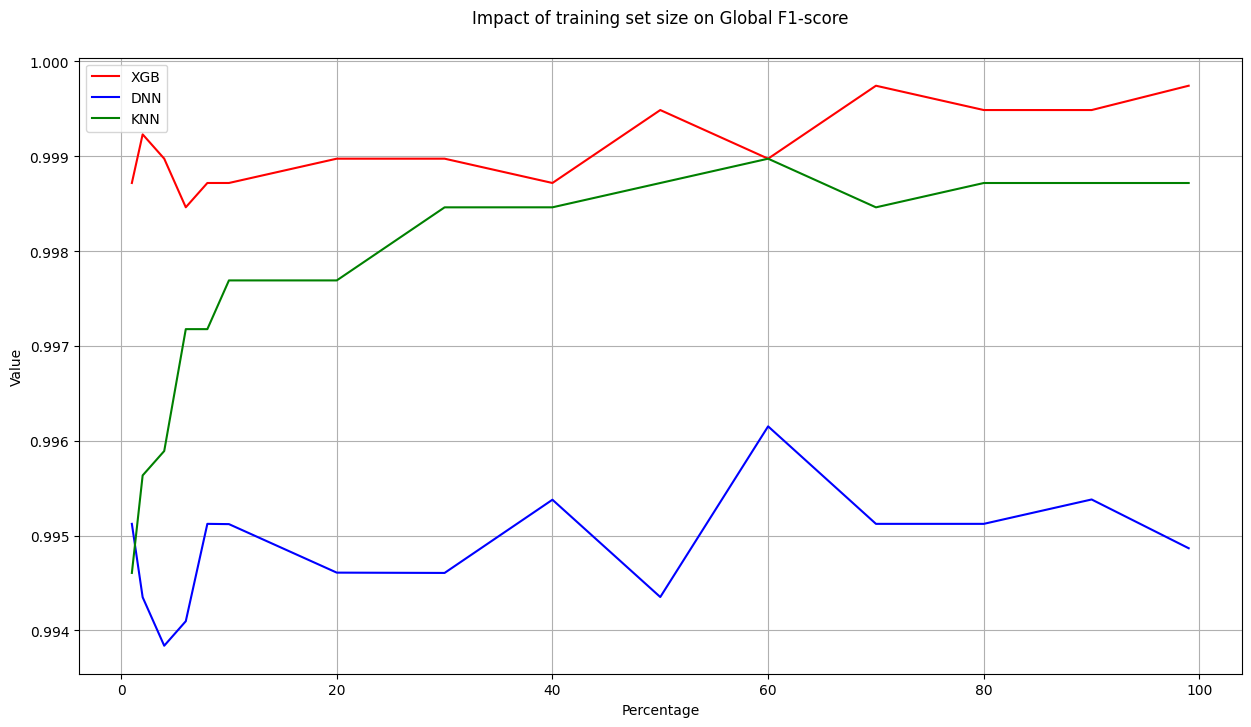

In [12]:
stats_labels = ['Accuracy', 'Global Precision', 'Global Recall', 'Global F1-score']

for i in range(0, len(stats_labels)):
    # Get the element "i" for each list inside the XXX_all_metrics list
    XGB_vals = [item[i] for item in XGB_all_metrics]
    DNN_vals = [item[i] for item in DNN_all_metrics]
    KNN_vals = [item[i] for item in KNN_all_metrics]
    draw_stats(XGB_vals, DNN_vals, KNN_vals, stats_labels[i])